##### This script will associate spoken phrases with their corresponding translation, using a convolutional neural network ("CNN")

This CNN will rely on 10 phrases I recorded myself saying 10 times each.

In [203]:
# ##### CNN Parameters #####

batch_size = 10
epochs = 70

image_height_width = 200  # Resize all images to square with this height and width

# AUGMENTATION OPTIONS 

# Option 2________________________________________________________________________________________________________________
mean_norm_img = True  # Normalize frequency of all images (training and test set)
blurr_img = True      # Blurr all images with gaussian blur (training and test set)


###########################

## (1) Load Packages and Functions

In [204]:
# Load packages

import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

# import matplotlib.pylab as plt
from skimage import data, img_as_float
from skimage import exposure
import random
import itertools
import librosa
import IPython.display as ipd

import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Sequential

from keras.layers import Activation
from keras.layers import Convolution2D, Dropout
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adamax
from keras.regularizers import l2
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [205]:
# ##### FUNCTIONS ##### #

def mean_norm(img):
    """
    A function that takes an image and deducts and divides by the column mean from each point of the array
    to normalize the frequency of each time frame.
    """
    img_mn = (img - (np.mean(img, axis=0) + 1e-8))  # / (np.mean(img, axis=0) + 1e-8)
    return img_mn


def augment_img(img, choose='random'):
    """
    A function that takes a 2D or 3D image and returns a randomly augmented version of the image,
    unless the augmentation type is specified on the call.
    """
    
    img_is_3d = False
    
    # Convert from 3D to 2D e.g. from (56, 56 , 1) to (56, 56)  * if the image came in as 3d
    if img.ndim == 3:
        img = np.squeeze(img)
        img_is_3d = True
    
    # Randomly choose augmentation method, unless specified
    if choose == 'random':
        options = ['AHE','CS','gamma','log','blurr_avg','blurr_gaus','blurr_median','None']
        choose = random.choice(options)
    
    # Adaptive Equalization
    if choose == 'AHE':
        img_new = exposure.equalize_adapthist(img, clip_limit=0.03)

    # Contrast stretching
    if choose == 'CS':
        p2 = np.percentile(img, 2)
        p98 = np.percentile(img, 98)
        img_new = exposure.rescale_intensity(img, in_range=(p2, p98))
        
    # Gamma contrast adjustment
    if choose == 'gamma':
        img_new = exposure.adjust_gamma(img, 2)
    
    # Log contrast adjustment
    if choose == 'log':
        img_new = exposure.adjust_log(img, 1)
        
    # Image Blurring - Averaging  - Note: n X n window. Smaller images will be blurred more
    if choose == 'blurr_avg':
        img_new = cv2.blur(img,(3,3))
        
    # Image Blurring - Gaussian  - Note: n X n window. Smaller images will be blurred more
    if choose == 'blurr_gaus':
        img_new = cv2.GaussianBlur(img,(5,5),0)

    # Image Blurring - Median Filtering 
    if choose == 'blurr_median':
        img_new = cv2.medianBlur(img,5)
        
    # Do nothing
    if choose == 'None':
        img_new = img
    
    # Convert back to 3D * if the image came in as 3d
    if img_is_3d == True:
        img_new = np.reshape(img_new, (img_new.shape[0], img_new.shape[1], 1)) 
    
    return img_new


def load_audio_file(file_path):
    data = librosa.core.load(file_path)[0] #, sr=16000
    return data


def plot_time_series(data):
    fig = plt.figure(figsize=(7, 4))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

    
def get_spectrogram(wav):
    D = librosa.stft(wav, n_fft=480, hop_length=160,
                     win_length=480, window='hamming')
    spect, phase = librosa.magphase(D)
    return np.log(spect)

#########################

## (2) Load Data & (3) Assign to test and train

In [206]:
prompt_master = pd.read_csv('../data/recorded/recorded_prompts.txt', sep="|", 
                      header=None, names=['prompt_id','prompt'])

In [207]:
prompt_master.head()
num_classes = len(prompt_master['prompt']) 
print('Unique prompts:', num_classes)

Unique prompts: 10


In [208]:
# Loop through all audio files and load spectrograms. Assign last 2 recordings of each prompt to test, and first 8 to train.
images = []
prompts = []
prompt_text = []
train = []

for p in range(1,11):
    print(prompt_master['prompt'][p-1])
    for i in range(1,11):
        aud_loc = '../data/recorded/' + str(p) + '_' + str(i) + '.wav'
        #print(aud_loc)
        data = load_audio_file(aud_loc)
        
        images.append(get_spectrogram(data))
        prompts.append(p-1)
        prompt_text.append(prompt_master['prompt'][p-1])
        
        train.append(1 if i <= 8 else -1)
    

what day is today
how are you
i am hungry
i need to go to the bathroom
i am tired
i am happy
i am sad
the quick brown fox jumped over the lazy dog
i want to go for a walk
please turn on the tv


In [209]:
print(len(images))
print(len(prompts))
print(len(train))

100
100
100


## (4) Resize All Images

In [210]:
# Resize images

images_orig = images
images = []

maxwidth = image_height_width

for i in images_orig:
    
    # Resize image
    img = cv2.resize(i, (maxwidth, maxwidth))
    images.append(img)   
    
    
print('Shape Before (example):', images_orig[0].shape)
print('Shape After (example):', images[0].shape)

Shape Before (example): (241, 249)
Shape After (example): (200, 200)


{0: 'what day is today', 1: 'how are you', 2: 'i am hungry', 3: 'i need to go to the bathroom', 4: 'i am tired', 5: 'i am happy', 6: 'i am sad', 7: 'the quick brown fox jumped over the lazy dog', 8: 'i want to go for a walk', 9: 'please turn on the tv'}


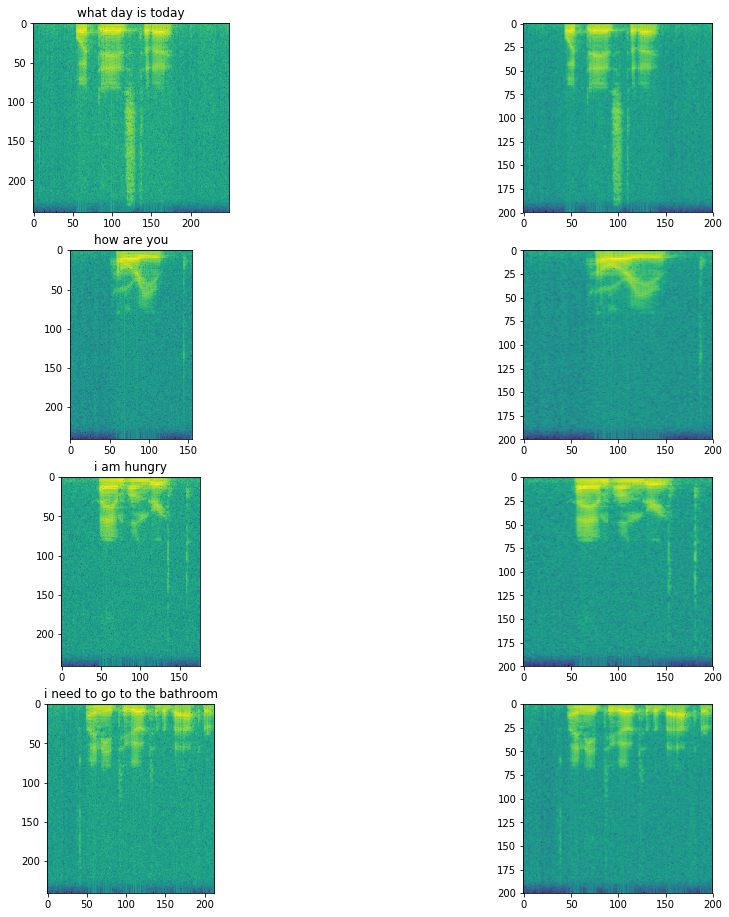

In [211]:
# View examples before and after re-size
# Note: These spectrograms are not flipped like the ones we made from TORGO data ! That is okay

cat = dict(zip(prompts, prompt_text))  # Dictionary to look up prompt text from prompt code
num_examples = 4

fig = plt.figure(figsize=(16, 16))

for i in range(num_examples):
    plt.subplot(num_examples,2,2*i + 1),plt.imshow(images_orig[i*10]),plt.title(cat.get(prompts[i*10]))
    plt.subplot(num_examples,2,2*i + 2),plt.imshow(images[i*10])
    
print(cat)

## (5) Explore Augmentation Techniques

##### Image Augmentation

(<matplotlib.axes._subplots.AxesSubplot at 0x1b31177d400>,
 Text(0.5,1,'After MN & Blur'))

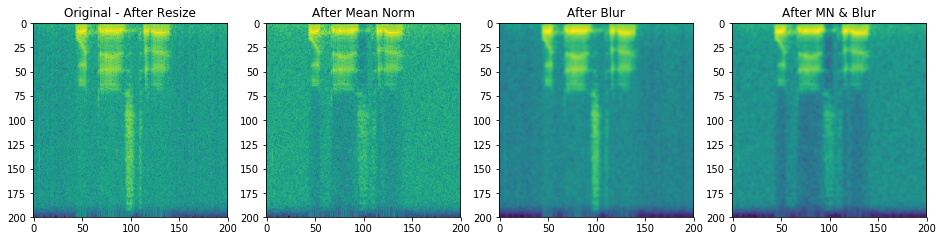

In [212]:
# View examples of mean normalization with gaussian blur
#   Note: Mean normalization looks similar to adding white noise. See below.

fig = plt.figure(figsize=(16, 16))

plt.subplot(1,4,1), plt.imshow(images[0]),plt.title('Original - After Resize')
plt.subplot(1,4,2), plt.imshow(mean_norm(images[0])),plt.title('After Mean Norm')
plt.subplot(1,4,3), plt.imshow(augment_img(images[0],'blurr_gaus')),plt.title('After Blur')
plt.subplot(1,4,4), plt.imshow(augment_img(mean_norm(images[0]),'blurr_gaus')),plt.title('After MN & Blur')

#print('Before mean norm:', images[0])
#print('After mean norm:', mean_norm(images[0]))

## (7) Apply Requested Augmentation

##### Audio Augmentation

##### Image Augmentation

In [213]:
# ############## IMAGE AUGMENTATION ############### #  

if mean_norm_img == True:
    images_new = []
    for i in images:
        images_new.append(mean_norm(i))
    images = images_new

if blurr_img == True:
    images_new = []
    for i in images:
        images_new.append(augment_img(i,'blurr_gaus'))
    images = images_new

if augment_images:
    # This also shifts the images horizontal or vertial by +/- x %
    datagen = ImageDataGenerator(width_shift_range=0.05, height_shift_range=0.05, preprocessing_function=augment_img)
else:
    datagen = ImageDataGenerator()

#####################################################

## (8) Set up and run CNN

Simple model is based on [this](https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/)

VGG model is based on [this](https://blogs.technet.microsoft.com/machinelearning/2018/01/30/hearing-ai-getting-started-with-deep-learning-for-audio-on-azure/)

In [214]:
# Split data into training and testing
x_train_pre = np.array([images[i] for i,x in enumerate(train) if x==1])
y_train_pre = np.array([prompts[i] for i,x in enumerate(train) if x==1])
x_test_pre = np.array([images[i] for i,x in enumerate(train) if x==-1])
y_test_pre = np.array([prompts[i] for i,x in enumerate(train) if x==-1])

x_train = x_train_pre
y_train = y_train_pre
x_test = x_test_pre
y_test = y_test_pre

print('Number of training records:', len(y_train))
print('Number of test records:', len(y_test))

Number of training records: 80
Number of test records: 20


In [215]:
# input image dimensions
img_x, img_y = maxwidth, maxwidth

In [216]:
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because it is in greyscale, we only have a single channel - RGB colour images would have 3
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)

In [217]:
# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (80, 200, 200, 1)
80 train samples
20 test samples


In [218]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8,
       8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9])

In [219]:
print(num_classes)

10


In [220]:
# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [221]:
# "Simple" Network (This is not the VGG network)

model = Sequential()

# Convolution 1st layer
model.add(Conv2D(64, kernel_size=(6, 6), strides=(4, 4),
                 activation='relu',
                 padding = 'same',
                 input_shape=input_shape,
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution 2nd layer
model.add(Conv2D(32, (4, 4), activation='relu', padding = 'same',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution 3rd layer
model.add(Conv2D(16, (2, 2), activation='relu', padding = 'same',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layer 1
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# # Fully connected layer 2
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization()) 

# Fully connected layer 3
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [222]:
# # VGG based network

# model = Sequential()

# # section 1

# model.add(Convolution2D(filters=32, kernel_size=5,
#                         strides=2,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal",
#                         input_shape=input_shape))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Convolution2D(filters=32, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Dropout(0.3))

# # section 2    
# model.add(Convolution2D(filters=64, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Convolution2D(filters=64, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

# # section 3
# model.add(Convolution2D(filters=128, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Convolution2D(filters=128, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Convolution2D(filters=128, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Convolution2D(filters=128, kernel_size=3,
#                         strides=1,
#                         padding="same",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

# # section 4
# model.add(Convolution2D(filters=512, kernel_size=3,
#                         strides=1,
#                         padding="valid",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Convolution2D(filters=512, kernel_size=1,
#                         strides=1,
#                         padding="valid",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# # section 5
# model.add(Convolution2D(filters=num_classes, kernel_size=1,
#                         strides=1,
#                         padding="valid",
#                         kernel_regularizer=l2(0.0001),
#                         kernel_initializer="normal"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(GlobalAveragePooling2D())

# model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adamax(0.01))

In [223]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

In [224]:
history = AccuracyHistory()

In [225]:
datagen.fit(x_train)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
          steps_per_epoch=x_train.shape[0] // batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/70
8/8 [==============================] - 7s 911ms/step - loss: 2.8099 - acc: 0.2750 - val_loss: 12.6355 - val_acc: 0.1000
Epoch 2/70
8/8 [==============================] - 4s 548ms/step - loss: 1.8883 - acc: 0.6500 - val_loss: 3.8336 - val_acc: 0.2500
Epoch 3/70
8/8 [==============================] - 5s 609ms/step - loss: 1.5856 - acc: 0.8000 - val_loss: 2.7141 - val_acc: 0.4000
Epoch 4/70
8/8 [==============================] - 5s 568ms/step - loss: 1.4582 - acc: 0.8000 - val_loss: 2.7401 - val_acc: 0.4000
Epoch 5/70
8/8 [==============================] - 4s 562ms/step - loss: 1.3411 - acc: 0.8375 - val_loss: 2.3611 - val_acc: 0.5500
Epoch 6/70
8/8 [==============================] - 4s 549ms/step - loss: 1.1156 - acc: 0.9625 - val_loss: 2.0446 - val_acc: 0.6000
Epoch 7/70
8/8 [==============================] - 5s 588ms/step - loss: 1.1134 - acc: 0.9250 - val_loss: 1.9491 - val_acc: 0.6000
Epoch 8/70
8/8 [==============================] - 5s 611ms/step - loss: 1.1601 - acc: 0.9

8/8 [==============================] - 5s 670ms/step - loss: 0.3579 - acc: 1.0000 - val_loss: 0.9994 - val_acc: 0.8500
Epoch 64/70
8/8 [==============================] - 5s 679ms/step - loss: 0.3367 - acc: 1.0000 - val_loss: 0.9726 - val_acc: 0.8500
Epoch 65/70
8/8 [==============================] - 6s 691ms/step - loss: 0.3330 - acc: 1.0000 - val_loss: 0.9337 - val_acc: 0.8500
Epoch 66/70
8/8 [==============================] - 5s 654ms/step - loss: 0.3258 - acc: 1.0000 - val_loss: 0.9568 - val_acc: 0.8500
Epoch 67/70
8/8 [==============================] - 5s 631ms/step - loss: 0.3278 - acc: 1.0000 - val_loss: 0.9722 - val_acc: 0.8000
Epoch 68/70
8/8 [==============================] - 5s 667ms/step - loss: 0.3275 - acc: 1.0000 - val_loss: 0.9902 - val_acc: 0.8500
Epoch 69/70
8/8 [==============================] - 5s 630ms/step - loss: 0.3201 - acc: 1.0000 - val_loss: 1.0092 - val_acc: 0.8500
Epoch 70/70
8/8 [==============================] - 5s 635ms/step - loss: 0.3189 - acc: 1.0000 -

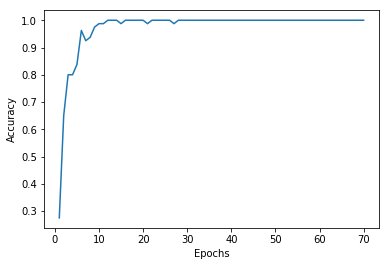

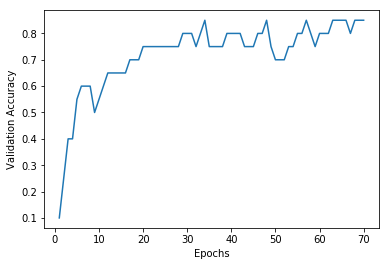

In [227]:
plt.plot(range(1, epochs + 1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(range(1, epochs + 1), history.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

##### Notes on results:

1) Width 150, simple network, no augmentation: up to 75%, sits around 70%

2) Width 150, simple network, mean norm and blurr: up to 90%, sits around 80% (maybe higher if trained longer)

3) Width 200, simple network, mean norm and blurr: up to 85%, sits around 85%


##### Ideas to improve

- [Use Keras to augment spectrograms, rather than the audio files](https://keras.io/preprocessing/image/)
    - [An example](https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085)
- [Use rubberband for audio file augmentation to build more training data](https://www.skcript.com/svr/building-audio-classifier-nueral-network/)
    - [Other non-rubberband augmentation code](https://github.com/drscotthawley/audio-classifier-keras-cnn/blob/master/augment_data.py)
- Try other hyper-parameters? (Dropout, learning rate, etc. Adding batch normalization seemed to help a little)
- Re-size spectrogram by creating a smaller freq axis, and randomly adding and removing time slices [Example code](https://github.com/dawidkopczyk/speech_recognition/blob/master/dataset.py)
- Use a different CNN structure, or use a recurrent CNN on the original images without shrinking?
    - [Tensorflow describes how to do this on different length audio files](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/speech_commands)
    - [This example](https://blogs.technet.microsoft.com/machinelearning/2018/01/30/hearing-ai-getting-started-with-deep-learning-for-audio-on-azure/) relies on a structure that has been known to perform well, and uses windowing and mel-spectrogram?
- Rather than using deep learning, use feature engineerings and autmated machine learning: Scale-invariant Feature Transform (SIFT) features + TPOT

In [152]:
# View actual vs predicted phrases

# model.predict(x_test)  # view prediction probabilities
predictions = model.predict_classes(x_test, verbose=1)
cat = dict( enumerate(df['prompt'].cat.categories) )
print(cat)

for i, val in enumerate(y_test_pre):
    print('Actual:', cat.get(val))
    print('Predicted:', cat.get(predictions[i]))
    print('----------------------------------------')

    
#Here is code for plotting 9 images in a 3x3 matrix. Can leverage this to print examples
# images = range(0,9)
# for i in images:
#     plt.subplot(330 + 1 + i)
#     plt.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))

20/20 [==============================] - 0s 15ms/step


NameError: name 'df' is not defined